In [2]:
import torch as t
import os
from glob import glob
import re
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [3]:
!pwd
os.chdir('txt')

/home/ubuntu


#### loading all data in memory, also processing it a bit

In [4]:
langs = glob('*')
data = []
for lang in langs:
    os.chdir(lang)
    files = glob('*')
    counter = 0
    for file in files:
        with open(file) as f:
            temp = f.readlines()
            for line in temp:
                if line[0] != '<':
                        line = re.sub(r'\([CLPNRFHEISDB][GKLNRVEUAISTO]\)', '', line)    #remove speaker lang annotantions
                        line = re.sub(r'[\xad\xa0\u200b\u202c\u202e\u202a\u202d�]', '', line) #remove invisible chars
                        if line[0] != '(':
                            if re.search(r'[眠舃舣脘舉]', line) == None:  #drop sentences with chinese chars
                                if line[0].isupper() == False:   #try to fix lines which start with lowercase
                                    temp2 = line.strip().split('. ')
                                    if len(temp2) > 1:
                                        line = ''.join([x + '. ' if i != len(temp2) -2 else x for i,x in enumerate(temp2[1:]) ])
                                if line[0].isupper() and len(line) < 50 and len(line) > 10: ##dropping long lines to save time
                                    ## ok, i've checked how long it takes to go through one paragraph,
                                    ## need to drop most of the data or try something else

                                    data.append((lang, line.strip()))
                                    #if lang = 'es' and counter < 5 and len(line) > 300:
                                    #    data.append((lang, line.strip()))
                                        
    os.chdir('..')


#### Checking the length of data and number of unique symbols (465 symbols)

In [5]:
np.random.shuffle(data)
np.random.shuffle(data)
print(len(data))
unique_letters = set()
for i in range(len(data)):
    unique_letters.update(set(data[i][1]))

378339


#### Splitting data  and making dicts to convert letters and languages

In [6]:
train = data[:200000] #1kk train
val = data[200000:300000] #300K validation
test = data[300000:]
keys_to_letters = dict(zip(range(len(unique_letters)), list(unique_letters)))
letters_to_keys = {val:key for key,val in keys_to_letters.items()}
punctuation = [key for key, item in keys_to_letters.items() if item in [' ', '.', ','] ]
key_to_lang = dict(zip(range(len(langs)), langs))
lang_to_key = {val:key for key,val in key_to_lang.items()}


In [7]:
def letter_to_onehot(letter):
    return t.eye(LETTERS_NUM)[letters_to_keys[letter]]

def letter_from_onehot(vec):
    idx = np.argmax(vec.cpu().numpy())
    return keys_to_letters[idx]

#### Defining network state sizes

In [8]:

LETTERS_NUM = len(unique_letters)
LANGS_NUM = len(langs)

INPUT_WINDOW_SIZE = 10
l1_shared = 64
l1_not = 64
l1_repr = 64
l2_shared = 64
l2_not = 64
l2_repr = 64
medium_repr = 64   

In [9]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
t.set_default_tensor_type('torch.cuda.FloatTensor')


#### was planning to use this to improve distributetd representations of input

In [10]:


class GAN(nn.Module):
    
    def __init__(self):
        super(GAN, self).__init__()
        
        self.layer1 = nn.Linear(LANGS_NUM + 50, 100)
        self.mod = nn.Linear(LETTERS_NUM + 100, 100)
        self.layer2 = nn.Linear(200 + LETTERS_NUM, 333)
        self.upd = nn.Linear(333, 256)
        self.state = t.zeros(256)
        self.last_out = t.zeros(LETTERS_NUM)
        self.out = nn.Linear(589, LETTERS_NUM)
        
    def forward(self, inputs):
        
        prestate = nn.ELU()(self.layer1(inputs))
        self.state = self.state * nn.Tanh()(self.mod(t.cat([prestate, self.last_out])))
        preupdate = nn.ELU()(self.layer2(t.cat([self.state, prestate, self.last_out])))
        self.state = self.state + nn.Tanh()(self.upd(preupdate))
        out = nn.Softmax(dim=0)(self.out(t.cat([self.state, preupdate])))
        _, index = t.max(out, 0, keepdim=True)
        self.last_out = out
        letter = t.eye(LETTERS_NUM)[index]
        return letter
    

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(1 + np.random.normal()*0.01)    #high bias for update functions

garbage_generator = GAN()
garbage_generator = garbage_generator.cuda()
garbage_generator.apply(init_weights)

GAN(
  (layer1): Linear(in_features=71, out_features=100, bias=True)
  (mod): Linear(in_features=445, out_features=100, bias=True)
  (layer2): Linear(in_features=545, out_features=333, bias=True)
  (upd): Linear(in_features=333, out_features=256, bias=True)
  (out): Linear(in_features=589, out_features=345, bias=True)
)

#### Helper function to generate data

In [11]:



index_train = 0
index_val = 0
index_test = 0
def gen_data(idx, mode='train', lang_hist=None):
    gen_data = []
    lang_n = -1
    letter = []
    punct = []
    real = []
    gan = 0
    data_onehot = []
    if mode == 'train' and np.random.rand() > 1:  #not enough time for this
        #data = []
        gan = 1
        lang_n = np.random.randint(0,LANGS_NUM)
        lang = key_to_lang[lang_n]
        gen_len = np.random.randint(15, 20)
        
        lang_base = t.eye(LANGS_NUM)[lang_n]
        for i in range(gen_len):
            seed = t.normal(t.zeros(50), t.ones(50))
            feed_in = t.cat([lang_base, seed])
            garbage = garbage_generator(feed_in)
            data_onehot.append(garbage)
        
    elif mode =='train':
        np.random.shuffle(train)
        lang, gen_data = train[idx]
        while lang in lang_hist:
            idx += 1
            lang, gen_data = train[idx]
            
        lang_hist.append(lang)
        data_onehot = [letter_to_onehot(x).view(1,-1) for x in gen_data]
    elif mode == 'validation':
        lang, gen_data = val[idx]
        data_onehot = [letter_to_onehot(x).view(1,-1) for x in gen_data]
    else:
        lang, gen_data = test[idx]
        data_onehot = [letter_to_onehot(x).view(1,-1) for x in gen_data]
        #make frames of data
    if gan == 1:
        n_frames = gen_len - INPUT_WINDOW_SIZE + 1
    else:
        n_frames = len(gen_data) - INPUT_WINDOW_SIZE + 1
    
    
        
    input_frames = t.empty(n_frames, INPUT_WINDOW_SIZE*LETTERS_NUM)
    lang = t.ones(n_frames,LANGS_NUM) * t.eye(LANGS_NUM)[lang_to_key[lang]]
    letters = t.empty(n_frames, LETTERS_NUM)
    punct = t.zeros(n_frames)
    
    for i in range(n_frames):
        letters[i] = data_onehot[i]
        input_frames[i] = t.cat(data_onehot[i: i+INPUT_WINDOW_SIZE], dim=1)
        if letter_from_onehot(data_onehot[i+INPUT_WINDOW_SIZE-1]) in [' ', ',', '.']:
            punct[i] = 1
            
    if gan == 0:
        real = t.ones(n_frames)
    else:
        real = t.zeros(n_frames)
        
        
    return input_frames, letters, punct, real, lang, lang_hist

#### Some modules I was palnning to use.

In [12]:


class Attention(nn.Module):

    def __init__(self, input_n, output_n):
        super(Attention, self).__init__()
        self.preprocess1 = nn.Linear(input_n, input_n)
        self.preprocess2 = nn.Linear(input_n, input_n)
        self.mask = nn.Linear(input_n, output_n)
        
    def forward(self, x):
        x = nn.ELU()(self.preprocess1(x))
        x = nn.Tanh()(self.preprocess2(x))
        x = nn.Sigmoid()(self.mask(x))
        return x


class Detector(nn.Module):
    
    def __init__(self, input_n):
        super(Detector, self).__init__()
        self.preprocess1 = nn.Linear(input_n, input_n)
        self.preprocess2 = nn.Linear(input_n, 16)
        self.detector = nn.Linear(16,2)
        
    def forward(self, x):
        x = nn.ELU()(self.preprocess1(x))
        x = nn.Tanh()(self.preprocess2(x))
        x = nn.Softmax(dim=0)(self.detector(x))
        return x

class ShortTerm(nn.Module):
    
    def __init__(self, input_n):
        super(ShortTerm, self).__init__()
        self.attention = Attention(input_n + l1_shared + l1_not, input_n)
        
        self.memory_shared = t.zeros(l1_shared) #shared mem is distributed representation of inputs
        self.memory = t.zeros(l1_not) #other mem is a state, that is communicated via medium
        
        
        
        #shared update
        #self.shared_preprocess = nn.Linear()
        self.preforget_shared = nn.Linear(input_n + l1_shared + l2_shared, l1_shared + l2_shared)
        self.forget_shared = nn.Linear(l1_shared + l2_shared, l1_shared)
        self.preupdate_shared = nn.Linear(input_n + l1_shared + l1_not, l1_shared + l1_not)
        self.update_shared = nn.Linear(l1_shared + l1_not, l1_shared)
        self.process_shared1 = nn.Linear(l1_shared + input_n, l1_repr)
        self.process_shared2 = nn.Linear(l1_repr, l1_repr)
        
        
        #other mem update
        self.preupdate_mem = nn.Linear(l1_shared + l1_not + medium_repr + l1_shared + l1_not, l1_not + medium_repr)
        self.update_mem = nn.Linear(l1_not + medium_repr, l1_not)
        
        self.last_shared = t.empty(l1_shared)
        
    def forward(self, obs, shared, medium):
        
        #get new observation to passs through attention
        attention =  self.attention(t.cat([obs, self.memory_shared, self.memory]))
        obs = obs * attention
        #save old shared state for updates
        self.last_shared = self.memory_shared
        
        #update shared_mem
        preforget_shared = nn.ELU()(self.preforget_shared(t.cat([obs, self.last_shared, shared])))
        forget_shared = nn.Sigmoid()(self.forget_shared(preforget_shared))
        self.memory_shared = self.memory_shared * forget_shared
        
        preupdate_shared = nn.ELU()(self.preupdate_shared(t.cat([obs, self.last_shared, self.memory])))
        update_shared = nn.Tanh()(self.update_shared(preupdate_shared))
        
        self.memory_shared = self.memory_shared + update_shared
        
        processed = nn.ELU()(self.process_shared1(t.cat([obs, self.memory_shared])))
        processed = nn.Tanh()(self.process_shared2(processed))
        #update other mem
        
        preupdate = nn.ELU()(self.preupdate_mem(t.cat([self.memory, self.memory_shared, medium, preupdate_shared])))
        update = nn.Tanh()(self.update_mem(preupdate))
        self.memory = self.memory * update
        
        return self.memory, self.memory_shared, processed
    
class LongTerm(nn.Module):
    
    def __init__(self, input_n):
        super(LongTerm, self).__init__()
        self.attention = Attention(input_n + l2_shared + l2_not + l1_shared, input_n)
        
        self.memory_shared = t.zeros(l2_shared) #shared mem is distributed representation of inputs
        self.memory = t.zeros(l2_not) #other mem is a state, that is communicated via medium
        
        #shared update
        self.preforget_shared = nn.Linear(input_n + l1_shared + l2_shared, l1_shared + l2_shared)
        self.forget_shared = nn.Linear(l1_shared + l2_shared, l2_shared)
        self.preupdate_shared = nn.Linear(input_n + l2_shared + l2_not, l2_shared + l2_not)
        self.update_shared = nn.Linear(l2_shared + l2_not, l2_shared)
        self.process_shared1 = nn.Linear(l2_shared + input_n, l2_repr)
        self.process_shared2 = nn.Linear(l2_repr, l2_repr)
        
        
        #other mem update
        self.preupdate_mem = nn.Linear(2*l2_shared + 2*l2_not + medium_repr, l2_shared + l2_not + medium_repr)
        self.update_mem = nn.Linear(l2_shared + l2_not + medium_repr, l2_not)
        
        self.last_shared = t.empty(l2_shared)
        
    
    def forward(self, obs, shared, medium):
        
        #get new observation to passs through attention
        attention =  self.attention(t.cat([shared, self.memory_shared, self.memory, obs]))
        obs = obs * attention
        
        #save old shared state for updates
        self.last_shared = self.memory_shared
        
        #update shared_mem
        preforget_shared = nn.ELU()(self.preforget_shared(t.cat([obs, self.last_shared, shared])))
        forget_shared = nn.Sigmoid()(self.forget_shared(preforget_shared))
        self.memory_shared = self.memory_shared * forget_shared
        
        preupdate_shared = nn.ELU()(self.preupdate_shared(t.cat([obs, self.last_shared, self.memory])))
        update_shared = nn.Tanh()(self.update_shared(preupdate_shared))
        self.memory_shared = self.memory_shared + update_shared
        
        
        processed = nn.ELU()(self.process_shared1(t.cat([obs, self.memory_shared])))
        processed = nn.Tanh()(self.process_shared2(processed))
        #update other mem
        
        preupdate = nn.ELU()(self.preupdate_mem(t.cat([self.memory, self.memory_shared, medium, preupdate_shared])))
        update = nn.Tanh()(self.update_mem(preupdate))
        self.memory = self.memory * update
        
        return self.memory, self.memory_shared, processed
    
    
class Medium(nn.Module):
    
    def __init__(self, input_n):
        super(Medium, self).__init__()
        self.attention = Attention(input_n + medium_repr, input_n)
        self.medium = t.zeros(medium_repr)
        self.preforget = nn.Linear(input_n + medium_repr, medium_repr)
        self.forget = nn.Linear(medium_repr, medium_repr)
        self.preupdate = nn.Linear(input_n + medium_repr + l1_shared + l2_shared + medium_repr, 2*medium_repr)
        self.update = nn.Linear(2*medium_repr, medium_repr)
        self.last_state = t.empty(medium_repr)
        
    def forward(self, st_mem, st_shared, lt_mem, lt_shared):
        #Input attention
        obs = t.cat([st_mem, st_shared, lt_mem, lt_shared])
        attention = self.attention(t.cat([obs, self.medium]))
        obs = obs * attention
        
        #Medium updates
        self.last_state = self.medium
        preforget = nn.ELU()(self.preforget(t.cat([obs, self.medium])))
        forget = nn.Sigmoid()(self.forget(preforget))
        self.medium = self.medium * forget
        
        preupdate = nn.ELU()(self.preupdate(t.cat([obs, self.last_state, st_shared, lt_shared, preforget])))
        update = nn.Tanh()(self.update(preupdate))
        self.medium = self.medium + update
        return self.medium
    

        
class Decoder(nn.Module):
    
    def __init__(self, input_n, out_n):
        super(Decoder, self).__init__()
        self.layer1 = nn.Linear(input_n, input_n)
        self.layer2 = nn.Linear(input_n, input_n)
        self.layer3 = nn.Linear(input_n, out_n)
        
    def forward(self, inputs):
        preprocess = nn.ELU()(self.layer1(inputs))
        representation = nn.Tanh()(self.layer2(preprocess))
        guess = nn.Softmax(dim=0)(self.layer3(representation))
        
        return guess
        

class LanguageDetector(nn.Module):
    
    def __init__(self):
        super(LanguageDetector, self).__init__()
        
        #Modules
        self.short_term = ShortTerm(LETTERS_NUM*INPUT_WINDOW_SIZE)
        self.long_term = LongTerm(l1_repr)
        self.medium = Medium(l1_shared + l1_not + l2_shared + l2_not)
        self.current_letter = Decoder(l1_shared + l1_repr, LETTERS_NUM)
        self.punctuation = Detector(l1_not + l1_repr) 
        self.word_real = Detector(l2_shared + l2_not + medium_repr)
        self.lang = Decoder(l2_shared + l2_not + medium_repr + l2_repr, LANGS_NUM)
        
        #Variables 
        self.medium_state = self.medium.medium
        self.short_term_shared = self.short_term.memory_shared
        self.short_term_mem = self.short_term.memory
        self.long_term_shared = self.long_term.memory_shared
        self.long_term_mem = self.long_term.memory
        
    def forward(self, inputs):
        #Short_term pass through
        
        self.short_term_mem, self.short_term_shared, data1 = self.short_term(inputs,\
                                                                      self.long_term_shared, self.medium_state)
        
        
        #Medium update
        
        self.medium_state = self.medium(self.short_term_mem, self.short_term_shared,\
                                       self.long_term_mem, self.long_term_shared)
        
        #long_term pass through
        self.long_term_mem, self.long_term_shared, data2 = self.long_term(data1,\
                                                                   self.short_term_shared, self.medium_state)
        
        #Another medium update
        
        self.medium_state = self.medium(self.short_term_mem, self.short_term_shared,\
                                       self.long_term_mem, self.long_term_shared)
        
        
        #Inference
        current_letter = self.current_letter(t.cat([self.short_term_shared, data1]))
        punctuation = self.punctuation(t.cat([self.short_term_mem, data1]))
        
        word_real = self.word_real(t.cat([self.long_term_shared, self.long_term_mem, self.medium_state]))
        lang = self.lang(t.cat([self.medium_state, self.long_term_mem, self.long_term_shared, data2]))
        
        return lang, current_letter, punctuation, word_real, data1, data2 #nevermind word_real, should've been renamed

    
#setting low bias for forget gates and high bias for update 
    
net = LanguageDetector()
net = net.cuda()
net.apply(init_weights)
net.short_term.preforget_shared.bias.data.fill_(0)
net.short_term.forget_shared.bias.data.fill_(0)
net.long_term.preforget_shared.bias.data.fill_(0)
net.long_term.forget_shared.bias.data.fill_(0)
net.medium.preforget.bias.data.fill_(0)
net.medium.forget.bias.data.fill_(0)
        

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### losses

In [ ]:


language_loss = nn.CrossEntropyLoss()   #main loss
letter_loss = nn.CrossEntropyLoss()#net supposed to decode first letter of input from state of shrt_trm and its output
real_word_loss = nn.CrossEntropyLoss()#to train gan
punctuation = nn.CrossEntropyLoss()#similar to letter loss but from different state and at the end of input window
repr1_loss = nn.CosineSimilarity(dim=0) #increase similarity of shrt_term outputs for same languages
repr2_loss = nn.CosineSimilarity(dim=0)#same but for long_term

gan_optimizer = t.optim.RMSprop(garbage_generator.parameters(), lr=0.001, momentum=0.6)


#### few more helper functions

In [13]:

from tqdm import trange

def reset_lang():
    net.short_term.memory = t.zeros(l1_not)
    net.short_term.memory_shared = t.zeros(l1_shared)
    net.long_term.memory = t.zeros(l2_not)
    net.long_term.memory_shared = t.zeros(l2_shared)
    net.medium.medium = t.zeros(medium_repr)
    net.medium_state = net.medium.medium
    net.short_term_shared = net.short_term.memory_shared
    net.short_term_mem = net.short_term.memory
    net.long_term_shared = net.long_term.memory_shared
    net.long_term_mem = net.long_term.memory
    
def evaluate():
    with t.no_grad():
        reset_lang()
        acc = []
        np.random.shuffle(val)
        for q in range(50):
            input_frames, letters, punct, real, lang, lang_hist = gen_data(q, mode='validation')
            predictions = t.zeros(LANGS_NUM)
            ans = t.ones_like(lang[0]) * -1
            for i in range(len(letters)):
                l, _,_,_,_,_ = net(input_frames[i])
                predictions = predictions + l
            _, ans = t.max(predictions,0)
            _, lang = t.max(lang[0],0)
            if ans == lang:
                acc.append(1)
            else:
                acc.append(0)
            reset_lang()   
        return sum(acc)/len(acc)
        
#evaluate()
#print(net.parameters)

#### Training

In [ ]:



import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

#plt.show()
fig, axs = plt.subplots(2,1, figsize=(15,7))
    
#training
from tqdm import trange

num_epochs = 1

repr1_hist = t.zeros(LANGS_NUM,l1_repr)
repr2_hist = t.zeros(LANGS_NUM,l2_repr)
index_train = 0


def detach_lang():
    net.short_term.memory = net.short_term.memory.detach()
    net.short_term.memory_shared = net.short_term.memory_shared.detach() 
    net.long_term.memory = net.long_term.memory.detach()
    net.long_term.memory_shared = net.long_term.memory_shared.detach
    net.medium.medium = net.medium.medium.detach()
    net.medium_state = net.medium_state.detach()
    net.short_term_shared = net.short_term_shared.detach()
    net.short_term_mem = net.short_term_mem.detach()
    net.long_term_shared = net.long_term_shared.detach()
    net.long_term_mem = net.long_term_mem.detach()

def reset_gan():
    garbage_generator.state = t.zeros(256)
    
loss_history = []
gan_loss_history = []
val_acc = []
lang_hist = []
for epoch in range(num_epochs):
    np.random.shuffle(train)
    for i in range(5000):
        reset_lang()
        if len(lang_hist) == 21:
            lang_hist = []
        input_frames, letters, punct, real, lang, lang_hist = gen_data(i, lang_hist=lang_hist)
        temp_loss = 0
        temp_gan_loss = 0
        
        for q in range(len(letters)):
            temp1 = np.argmax(lang[q].cpu().numpy())
            temp2 = temp1.copy()
            while temp2 == temp1:
                temp2 = np.random.randint(0,LANGS_NUM)
            
            detected_lang, detected_letter, detected_punct, detected_real, repr1, repr2 = net(input_frames[q])
            
            lang_loss1 = language_loss(detected_lang.view((1,-1)), lang[q].max(0)[1].long().view(1)) 
            lang_loss2 =  letter_loss(detected_letter.view((1,-1)), letters[q].max(0)[1].long().view(1)) 
            lang_loss3 = punctuation(detected_punct.view((1,-1)), punct[q].long().view(1))
            lang_loss4 = real_word_loss(detected_real.view((1,-1)), real[q].long().view(1))
            lang_loss5 = F.cosine_similarity(repr1, repr1_hist[temp2], dim=0) - F.cosine_similarity(repr1, repr1_hist[temp1], dim=0)
            lang_loss6 = F.cosine_similarity(repr2, repr2_hist[temp2], dim=0) - F.cosine_similarity(repr2, repr2_hist[temp1], dim=0)
            #if i > 20:
            #    lang_loss = lang_loss1 + lang_loss2 + lang_loss3 + lang_loss4 + lang_loss5 + lang_loss6
            #else:
            lang_loss = lang_loss1 + lang_loss2 + lang_loss3 + lang_loss4
            if real[0] == t.zeros(1):
                gan_loss = language_loss(detected_lang.view((1,-1)), lang[q].max(0)[1].long().view(1)) + letter_loss(detected_letter.view((1,-1)), letters[q].max(0)[1].long().view(1)) + \
                punctuation(detected_punct.view((1,-1)), punct[q].long().view(1)) + real_word_loss(detected_real.view((1,-1)), t.ones(1).long().view(1)) +\
                F.cosine_similarity(repr1, repr1_hist[temp2], dim=0) - F.cosine_similarity(repr1, repr1_hist[temp1], dim=0) +\
                F.cosine_similarity(repr2, repr2_hist[temp2], dim=0) - F.cosine_similarity(repr2, repr2_hist[temp1], dim=0)
            else:
                gan_loss = 0
                
            
            lang_optimizer.zero_grad()
            #gan_optimizer.zero_grad()
            
            lang_loss.backward(retain_graph=True)
            lang_optimizer.step()
            
            #if gan_loss != 0:
            #    gan_loss.backward(retain_graph=True)
            #    gan_optimizer.step()
            #    temp_gan_loss += gan_loss
                
            temp_loss += lang_loss.item()
            
            #
            #if q %10 == 0:
            #    detach_lang()
            #    reset_lang()
                
                
            repr1_hist[temp1] = repr1.clone()
            repr2_hist[temp1] = repr2.clone()
        detach_lang()
        reset_lang()
        reset_gan()

        if i % 10 == 0:# and temp_gan_loss != 0: 
            loss_history.append(temp_loss/(q+1))
            val_acc.append(evaluate())
            #gan_loss_history.append(temp_gan_loss/(q+1))
            axs[0].plot(loss_history)
            axs[1].plot(val_acc)
            display.clear_output(wait=True)
            display.display(plt.gcf())
           

Training slows down a lot when representations similarity kicks in (like 10-20x)
However it's very slow even without representation losses

It's almost deadline, will just train lstm.

In [22]:
class Simple(nn.Module):
    def __init__(self):
        super(Simple, self).__init__()
        self.embedding = nn.Linear(LETTERS_NUM*INPUT_WINDOW_SIZE, 128) #semi embedding
        self.lstm = nn.LSTM(128,128, 2)
        self.preout = nn.Linear(128,64)
        self.out = nn.Linear(64,LANGS_NUM)
        self.hidden = t.zeros(2,1,128)
        self.last = t.zeros(2,1,128)
        
    def forward(self, inputs):
        embeddings = nn.ELU()(self.embedding(inputs))
        embeddings = embeddings.view(embeddings.size()[0], 1, embeddings.size()[1])
        lstm_out, (self.hidden, self.last) = self.lstm(embeddings, (self.hidden, self.last))
        preout = nn.ELU()(self.preout(lstm_out))
        out = nn.Softmax(dim = 2)(self.out(preout))
        return out
    

    
net2 = Simple()
net2.apply(init_weights)
net2 = net2.cuda()

def reset_net2():
    net2.hidden = net2.hidden.detach()
    net2.last = net2.last.detach()
    net2.hidden = t.zeros(2,1,128)
    net2.last = t.zeros(2,1,128)
    
def evaluate_simple():
    with t.no_grad():
        reset_net2()
        acc = []
        np.random.shuffle(val)
        for q in range(100):
            
            input_frames, _, _, _, lang, lang_hist = gen_data(q, mode='validation')
            predictions = t.zeros(LANGS_NUM)
            ans = t.ones_like(lang[0]) * -1
            l = net2(input_frames)
            predictions = t.sum(l, 0)
            _, ans = t.max(predictions,1)
            _, lang = t.max(lang[0],0)
            if ans[0] == lang:
                acc.append(1)
            else:
                acc.append(0)
            reset_net2()   
        return sum(acc)/len(acc)
    
#evaluate_simple()

KeyboardInterrupt: 

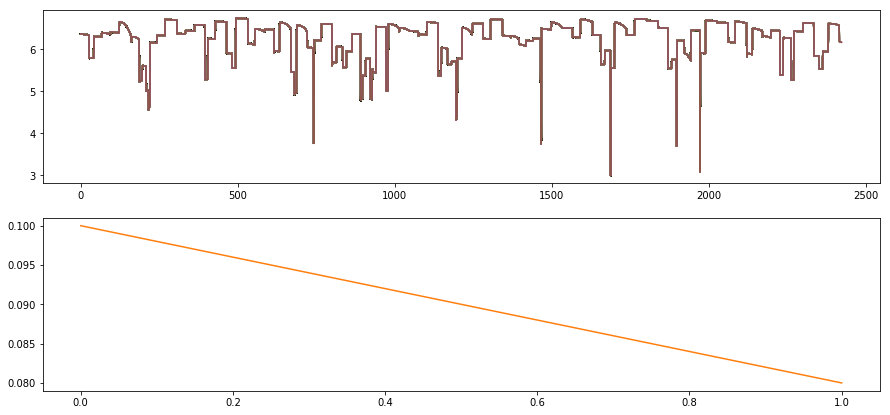

In [23]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
from tqdm import trange
lang_optimizer = t.optim.Adam(net2.parameters(), lr=3e-5)#, amsgrad=True)
#lang_optimizer = t.optim.SGD(net2.parameters(), lr=1e-4, momentum=0.8, weight_decay=1e-7)

num_epochs = 1
fig, axs = plt.subplots(2,1, figsize=(15,7))


repr1_hist = t.zeros(LANGS_NUM,l1_repr)
repr2_hist = t.zeros(LANGS_NUM,l2_repr)
index_train = 0

loss_history = []
gan_loss_history = []
val_acc = []
plot_x = [0]
lang_hist = []
loss_calculator = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    np.random.shuffle(train)
    for i in range(500):
        reset_net2()
        if len(lang_hist) == 21:
            lang_hist = []
        input_frames, _, _, _, lang, lang_hist = gen_data(i, lang_hist=lang_hist)
        temp_loss = 0
        temp_gan_loss = 0
        for q in range(len(lang)):
            temp1 = np.argmax(lang[q].cpu().numpy())
            temp2 = temp1.copy()
            while temp2 == temp1:
                temp2 = np.random.randint(0,LANGS_NUM)
            
            lang_prediction = net2(input_frames)
            lang_loss = loss_calculator(lang_prediction.view((1,-1)), lang[q].max(0)[1].long().view(1))
            lang_optimizer.zero_grad()
            
            lang_loss.backward(retain_graph=True)
            lang_optimizer.step()
            
            temp_loss += lang_loss.item()
            axs[0].plot(loss_history)
            display.clear_output(wait=True)
            display.display(plt.gcf())
        
            loss_history.append(lang_loss.item())   
        reset_net2()

        if i % 100 == 0:# and temp_gan_loss != 0:    
            
            #gan_loss_history.append(temp_gan_loss/(q+1))
            val_acc.append(evaluate_simple())
            axs[1].plot(val_acc)
            #plt.plot(gan_loss_history)
            axs[0].plot(loss_history, color='green')
            display.clear_output(wait=True)
            display.display(plt.gcf())
           

##### Somehow lstm trains not much faster than my network. 

Some results will be in the bottom of another notebook (part2)